In [2]:
import sys, os
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator

h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,25 mins 22 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,2 hours and 33 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.42 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


https://research.googleblog.com/2016/08/improving-inception-and-image.html

![inception_resnet_v2](images/inception-resnetv2.png)

## Data Ingest
#### Image dataset
For simplicity, H2O Deep Water allows you to specify a list of URIs (file paths) or URLs (links) to images, together with a response column (either a class membership (enum) or regression target (numeric)).

For this example, we use this simple cat/dog/mouse dataset that has a few hundred images, and a label of cardinality 3.

In [13]:
frame = h2o.import_file("/home/arno/h2o-3/bigdata/laptop/deepwater/imagenet/cat_dog_mouse.csv")
print(frame.dim)
print(frame.head(5))

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%
[267, 2]


C1,C2
bigdata/laptop/deepwater/imagenet/cat/102194502_49f003abd9.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/11146807_00a5f35255.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1140846215_70e326f868.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/114170569_6cbdf4bbdb.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1217664848_de4c7fc296.jpg,cat


Let's look at a random subset of 10 images

['bigdata/laptop/deepwater/imagenet/cat/34078517_49aeaaf182.jpg', 'bigdata/laptop/deepwater/imagenet/dog/976284069_dc3401cfd4.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/315165014_6f2094a7a7.jpg', 'bigdata/laptop/deepwater/imagenet/dog/57104973_d32fbaf377.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/66473383_9d4cf5c7c6.jpg', 'bigdata/laptop/deepwater/imagenet/dog/513779728_e5f268ef52.jpg', 'bigdata/laptop/deepwater/imagenet/dog/1114031303_03c6f21c53.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/2174164084_ee5e10211e.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/1170346431_040eeb70d4.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/99974652_1b4c1fb920.jpg']


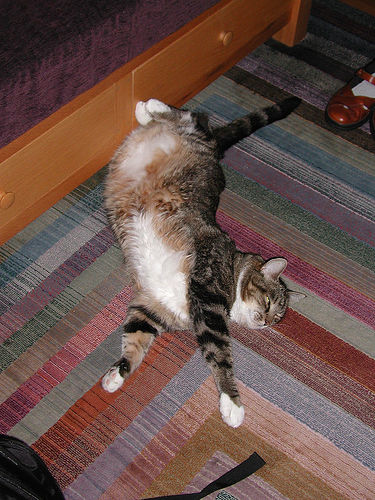

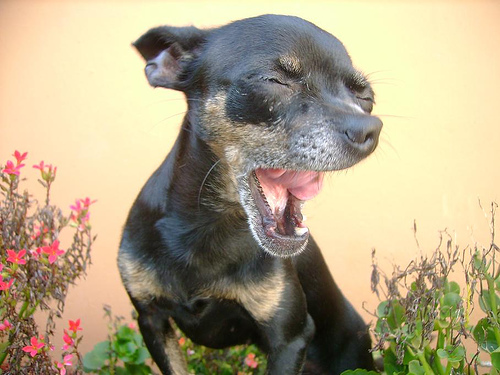

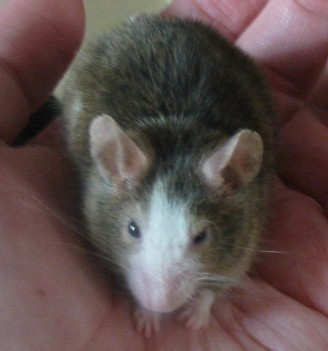

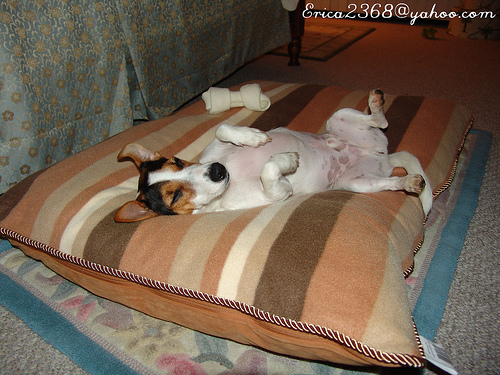

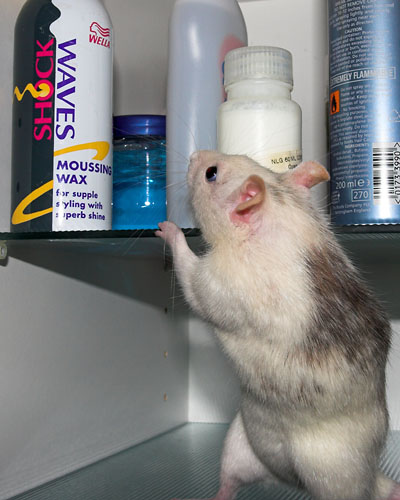

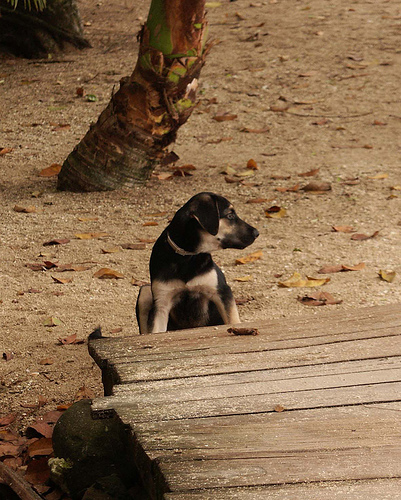

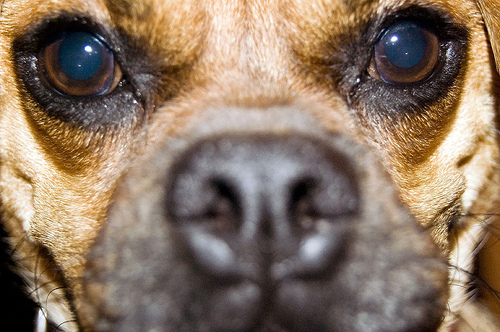

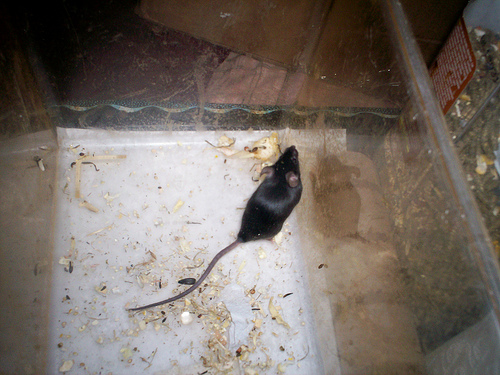

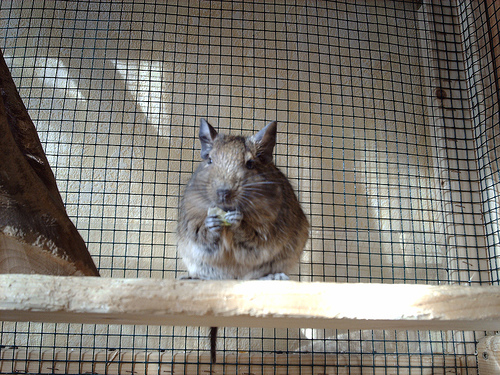

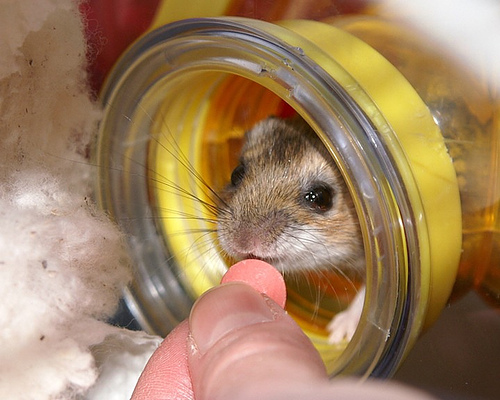

In [14]:
from IPython.display import Image, display, HTML
import pandas as pd
import random
images = frame[:,0].as_data_frame(use_pandas=False)
which = list(random.sample(xrange(frame.nrow), 10))
sample = [images[x][0] for x in which]
print(sample)
for x in sample:
    display(Image(filename="/home/arno/h2o-3/"+x))

Now, we build a classic convolutional neural network, called [LeNet](http://yann.lecun.com/exdb/lenet/)
![LeNet](images/lenet.gif)
![LeNet](images/lenet.jpg)

We'll use a GPU to train such a LeNet model in seconds

In [19]:
!nvidia-smi

Sat Oct 22 18:50:12 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.44                 Driver Version: 367.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980 Ti  Off  | 0000:01:00.0      On |                  N/A |
|  8%   62C    P0    77W / 275W |    993MiB /  6076MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 0000:02:00.0     Off |                  N/A |
| 31%   56C    P2    71W / 250W |   3810MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [21]:
model = H2ODeepWaterEstimator(epochs=500, network = "lenet")
model.train(x=[0],y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477185117781_12
Status of Deep Learning Model: lenet, 1.6 MB, predicting C2, 3-class classification, 134,144 training samples, mini-batch size 32



,input_neurons,rate,momentum
,2352,0.0044086,0.99




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 3.552272968e-06
RMSE: 0.0018847474547
LogLoss: 0.00103339301354
Mean Per-Class Error: 0.0
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
90.0,0.0,0.0,0.0,0 / 90
0.0,85.0,0.0,0.0,0 / 85
0.0,0.0,92.0,0.0,0 / 92
90.0,85.0,92.0,0.0,0 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-22 18:51:08,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-22 18:51:09,1.118 sec,1027 obs/sec,3.8352060,1,1024.0,0.6809679,1.3641228,0.6292135
,2016-10-22 18:51:14,6.195 sec,11310 obs/sec,256.9588015,67,68608.0,0.3785865,0.4285856,0.1872659
,2016-10-22 18:51:19,10.965 sec,12387 obs/sec,502.4119850,131,134144.0,0.0018847,0.0010334,0.0
